In [2]:
import pandas as pd
import json
from pathlib import Path
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
print(pd.__version__)
df = pd.read_json('radical/analyse_fase-kenmerken_onderzoek/Data/dp-set2-cleaned.jsonl.gz', orient='records', lines=True, compression='gzip')
df.head()

model_name = "tabularisai/multilingual-sentiment-analysis"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

3.0.0


Loading weights:   0%|          | 0/104 [00:00<?, ?it/s]

In [3]:

def predict_in_batches(texts, batch_size=32):
    all_labels = []
    all_confidences = []

    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]

        inputs = tokenizer(
            batch,
            return_tensors="pt",
            truncation=True,
            padding=True,
            max_length=512
        )

        with torch.no_grad():
            outputs = model(**inputs)

        probs = torch.nn.functional.softmax(outputs.logits, dim=-1)

        sentiment_map = {
            0: "Very Negative",
            1: "Negative",
            2: "Neutral",
            3: "Positive",
            4: "Very Positive"
        }

        for p in probs:
            idx = torch.argmax(p).item()
            all_labels.append(sentiment_map[idx])
            all_confidences.append(float(p[idx]))

    return all_labels, all_confidences


In [4]:
labels, confs = predict_in_batches(df["content.text"].astype(str).tolist(), batch_size=16)

df["sentiment"] = labels
df["confidence"] = confs

#exporteren van gelabelde dataset
# df.to_json('radical/analyse_fase-kenmerken_onderzoek/Data/dp-set2-sentiment-labeld.jsonl.gz', orient='records', lines=True, compression='gzip')

/tmp/ipykernel_49407/2938843309.py:7: Pandas4Warning: The default 'epoch' date format is deprecated and will be removed in a future version, please use 'iso' date format instead.
  df.to_json('radical/analyse_fase-kenmerken_onderzoek/Data/dp-set2-sentiment-labeld.jsonl.gz', orient='records', lines=True, compression='gzip')


### Downloaden van Model
from huggingface_hub import snapshot_download

local_path = snapshot_download(
    repo_id="siebert/sentiment-roberta-large-english",
    local_dir="./models/siebert-sentiment-roberta-large-english",
    token=False,                 # gebruikt je login automatisch
    local_dir_use_symlinks=False
)

print("Downloaded to:", local_path)

#### Testen van model


In [5]:
df.head()
df.tail()

,source,scraped_at,media,keywords_hit,thread.url,thread.title,thread.page_url,thread.page_num,post.id,post.author,post.created_at,content.text,content.html,entities.links,sentiment,confidence
4581,debatepolitics,2026-01-28 13:57:34.015954+00:00,[],[ice officer],https://debatepolitics.com/threads/is-anybody-...,Is anybody here a military veteran or LEO,https://debatepolitics.com/threads/is-anybody-...,1,1064635182,LuddlyNeddite,2015-05-18T22:52:20-0400,I served in the Army for 8 years. 3rd Infantry...,"<div class=""bbWrapper"">I served in the Army fo...",[],Neutral,0.840293
4582,debatepolitics,2026-01-28 13:57:34.015954+00:00,"[{'type': 'image', 'url': 'https://cdn.jsdeliv...",[ice officer],https://debatepolitics.com/threads/is-anybody-...,Is anybody here a military veteran or LEO,https://debatepolitics.com/threads/is-anybody-...,1,1064635198,cpwill,2015-05-18T22:57:46-0400,LuddlyNeddite said: I served in the Army for 8...,"<div class=""bbWrapper""><blockquote class=""bbCo...",[{'url': 'https://debatepolitics.com/goto/post...,Positive,0.729241
4583,debatepolitics,2026-01-28 13:57:44.318161+00:00,[],[ice officer],https://debatepolitics.com/threads/mexicos-sec...,"Mexico's ""second amendment"" contributes to it'...",https://debatepolitics.com/threads/mexicos-sec...,3,1064652651,Peter King,2015-05-24T15:02:38-0400,TurtleDude said: you'd be wrong lots of the ca...,"<div class=""bbWrapper""><blockquote class=""bbCo...",[{'url': 'https://debatepolitics.com/goto/post...,Neutral,0.909243
4584,debatepolitics,2026-01-28 13:57:49.019840+00:00,[],[ice officer],https://debatepolitics.com/threads/mexicos-sec...,"Mexico's ""second amendment"" contributes to it'...",https://debatepolitics.com/threads/mexicos-sec...,2,1064652651,Peter King,2015-05-24T15:02:38-0400,TurtleDude said: you'd be wrong lots of the ca...,"<div class=""bbWrapper""><blockquote class=""bbCo...",[{'url': 'https://debatepolitics.com/goto/post...,Neutral,0.909243
4585,debatepolitics,2026-01-28 13:57:52.086965+00:00,[],[ice officer],https://debatepolitics.com/threads/mexicos-sec...,"Mexico's ""second amendment"" contributes to it'...",https://debatepolitics.com/threads/mexicos-sec...,1,1064652651,Peter King,2015-05-24T15:02:38-0400,TurtleDude said: you'd be wrong lots of the ca...,"<div class=""bbWrapper""><blockquote class=""bbCo...",[{'url': 'https://debatepolitics.com/goto/post...,Neutral,0.909243


In [6]:
df['sentiment'].value_counts()

sentiment
Neutral          2033
Negative         1883
Very Negative     540
Positive           97
Very Positive      33
Name: count, dtype: int64

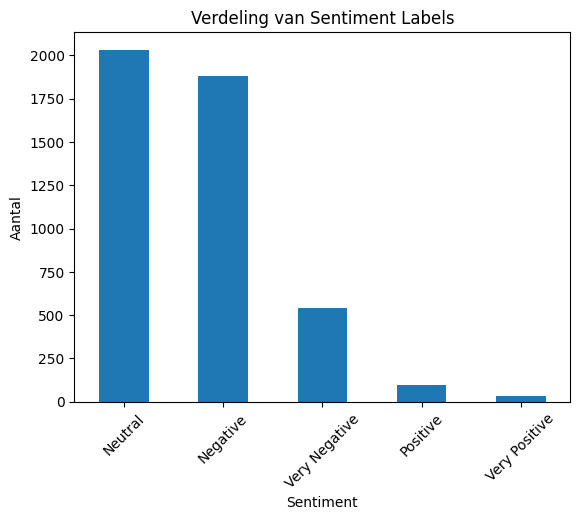

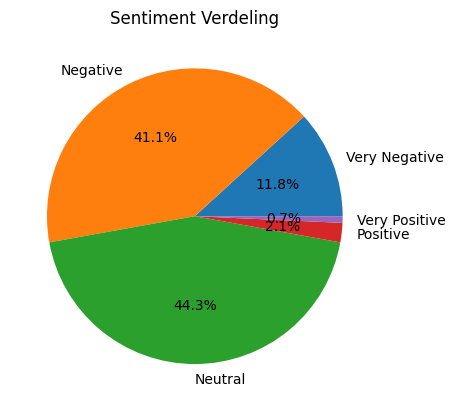

In [9]:
import matplotlib.pyplot as plt

order = ["very negative", "negative", "neutral", "positive", "very positive"]
sentiment_counts = df["sentiment"].value_counts().reindex(order)

explode = [0.05] * len(sentiment_counts)

plt.figure()
plt.pie(sentiment_counts, 
        labels=sentiment_counts.index, 
        autopct='%1.1f%%',
        explode=explode)

plt.title("Sentiment Verdeling")
plt.show()


ValueError: cannot convert float NaN to integer

ValueError: need at least one array to concatenate

<Figure size 640x480 with 1 Axes>